In [1]:
import random
from collections import defaultdict
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt


In [2]:
bookPath = "goblet_book.txt"

with open(bookPath) as f:
    bookContent = f.read() #string

alphabet = sorted(set(bookContent))
K = len(alphabet)

print(K)
print("".join(alphabet))

83
	
 !"'(),-./01234679:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ^_abcdefghijklmnopqrstuvwxyz}¢¼Ãâ€


In [3]:
index_to_char = {i: char for i, char in enumerate(alphabet)}
char_to_index = {char: i for i, char in enumerate(alphabet)}


In [4]:
def string2vec(string):
    vec = np.array([char_to_index[c] for c in string])
    return vec

def oneHotEncode(idx):
    N = len(idx) if type(idx) is np.ndarray else 1
    one_hot_matrix = np.zeros((N, K))
    one_hot_matrix[np.arange(N), idx] = 1
    return one_hot_matrix.T

def string2oneHot(string):
    vec = string2vec(string)
    return oneHotEncode(vec)

def oneHot2String(oneHot):
    vec = np.argmax(oneHot, axis=0)
    string = ''.join([index_to_char[idx] for idx in vec])
    return string

oneHot = string2oneHot("Hi")
print(oneHot.shape)
print(oneHot.T)

string = oneHot2String(oneHot)
print(string)


(83, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Hi


In [53]:
global num_grads

class Weights:
    def __init__(self, chars, hiddenDim, sig):
        self.b = np.zeros((hiddenDim, 1))
        self.c = np.zeros((chars, 1))
        self.U = np.random.normal(0, sig, (hiddenDim, chars))
        self.W = np.random.normal(0, sig, (hiddenDim, hiddenDim))
        self.V = np.random.normal(0, sig, (chars, hiddenDim))


class Grads:
    def __init__(self, chars, hiddenDim):
        self.b = np.zeros((hiddenDim, 1))
        self.c = np.zeros((chars, 1))
        self.U = np.zeros((hiddenDim, chars))
        self.W = np.zeros((hiddenDim, hiddenDim))
        self.V = np.zeros((chars, hiddenDim))


class RNN:
    def __init__(self, chars, hiddenDim, seqLength, eta, sig = 0.01):
        self.chars = chars
        self.hiddenDim = hiddenDim
        self.seqLength = seqLength
        self.eta = eta
        self.sig = sig

        self.weights = Weights(chars, hiddenDim, sig)
        self.grads = Grads(chars, hiddenDim)
        self.ada_grads = Grads(chars, hiddenDim)

        self.h0 = np.zeros((hiddenDim, 1))
        self.dummy = "."

        self.cache = defaultdict(list)


    def relu(self, X, d=False):
        if not d:
            return np.maximum(0, X)
            # np.where(X > 0, X, 0)
        else:
            return np.where(X > 0, 1, 0)


    def softmax(self, x: np.ndarray) -> np.ndarray:
        """ Standard definition of the softmax function """
        exps = np.exp(x)
        return exps / np.sum(exps, axis=0)


    def ForwardPassSingle(self, X, h_prev):
        assert X.shape[0] == self.chars

        a = self.weights.W @ h_prev    # 100x100 @ 100x1 = 100x1
        a += self.weights.U @ X        # + 100x83 @ 83x1 = 100x1
        a += self.weights.b            # + 100x1
        h = np.tanh(a)

        o = self.weights.V @ h + self.weights.c
        p = self.softmax(o)

        assert h.shape[0] == self.hiddenDim
        assert p.shape[0] == self.chars

        return p, h, a


    # def Sample(self, probability_vec):
    #     cp = np.cumsum(probability_vec)
    #     a = np.random.rand()
    #     ixs = np.nonzero(cp - a > 0)[0]   # remove tuple for dimensionality -> P is 1d
    #     idx = ixs[0]
    #     return idx


    def ComputeLoss(self, Y_pred, Y_true):
        _loss = - Y_true * np.log(Y_pred)
        loss = np.sum(_loss)
        # sum across chars (axis=0) for loss per seq
        # then sum along seq (axis=1) for overall loss

        return np.squeeze(loss)


    def ComputeLossForNumGrad(self, X, Y_true, weigths_try, h_prev):
        safe_weights = copy.deepcopy(self.weights)
        safe_cache = copy.deepcopy(self.cache)

        self.weights = weigths_try

        Y_pred, _ = self.ForwardPass(X, h_prev)
        loss = self.ComputeLoss(Y_pred, Y_true)

        # reset everything^^
        self.cache = safe_cache
        self.weights = safe_weights

        return loss


    def SynthesizeText(self, x0, h0, seqLength):
        prediction = []
        assert x0.shape == (self.chars, 1)
        x = x0
        h = h0

        for i in range(seqLength):
            p, _, _ = self.ForwardPassSingle(x, h)
            # idx = self.Sample(p)
            idx = np.random.choice(self.chars, p=np.squeeze(p))
            prediction.append(index_to_char[idx])
            x = oneHotEncode(idx)

        return "".join(prediction)


    def ForwardPass(self, X, h_prev):
        assert X.shape == (self.chars, self.seqLength)

        self.cache = defaultdict(list)

        predictions = []
        h = h_prev

        for t in range(self.seqLength):
            x = X[:, t, None]

            self.cache["x"].append(x)
            self.cache["h_prev"].append(h)

            p, h, a = self.ForwardPassSingle(x, h)
            predictions.append(p)

            self.cache["h"].append(h)
            self.cache["a"].append(a)
            self.cache["p"].append(p)

        predictions = np.asarray(predictions).squeeze().T
        assert predictions.shape == (self.chars, self.seqLength)

        return predictions, h


    def BackwardPassSingle(self, Y_pred, Y_true, da_next, h_next, h_prev, xt, a):
        dy = Y_pred - Y_true

        # gradients wrt y
        self.grads.V += dy @ h_next.T
        self.grads.c += dy

        dh = self.weights.V.T @ dy + da_next
        da = dh * (1 - np.tanh(a)**2)

        # gradients wrt hidden
        self.grads.b += da
        self.grads.U += da @ xt.T
        self.grads.W += da @ h_prev.T

        da_next = self.weights.W.T @ da
        return da_next


    def BackwardPass(self, X, Y_pred, Y_true):
        assert X.shape == Y_pred.shape == Y_true.shape == (self.chars, self.seqLength)

        # initialize gradients
        self.grads = Grads(self.chars, self.hiddenDim)
        dh_next = np.zeros((self.hiddenDim, 1))

        # BPTT
        for i in reversed(range(self.seqLength)):
            assert dh_next.shape == (self.hiddenDim, 1)
            dh_next = self.BackwardPassSingle(self.cache["p"][i],
                                              Y_true[:, i, None],   # None adds empty axis for transpose
                                              dh_next,
                                              self.cache["h"][i],
                                              self.cache["h_prev"][i],
                                              self.cache["x"][i],
                                              self.cache["a"][i])

        assert self.grads.W.shape == self.weights.W.shape
        assert self.grads.U.shape == self.weights.U.shape
        assert self.grads.b.shape == self.weights.b.shape
        assert self.grads.c.shape == self.weights.c.shape
        assert self.grads.V.shape == self.weights.V.shape

        self.ClipGradients()


    def ComputeGradsNum(self, X, Y, hprev, h=1e-4):
        num_grads = Grads(self.chars, self.hiddenDim)

        for f in self.weights.__dict__.keys():
            num_grads.__dict__[f] = self.ComputeGradNum(X, Y, f, hprev, h)
        return num_grads


    def ComputeGradNum(self, X, Y, f, hprev, h):
        grad = np.zeros_like(self.weights.__dict__[f])

        for i in np.ndindex(self.weights.__dict__[f].shape):
            weights_try = copy.deepcopy(self.weights)
            weights_try.__dict__[f][i] -= h
            l1 = self.ComputeLossForNumGrad(X, Y, weights_try, hprev)
            weights_try.__dict__[f][i] += 2 * h
            l2 = self.ComputeLossForNumGrad(X, Y, weights_try, hprev)
            grad[i] = (l2 - l1) / (2 * h)
        return grad


    def ClipGradients(self, value = 5):
        for f in self.grads.__dict__.keys():
            self.grads.__dict__[f] = np.clip(self.grads.__dict__[f], a_min=-value, a_max=value)


    def SGDStep(self):
        for f in self.weights.__dict__.keys():
            # self.ada_grads.__dict__[f] = self.gamma * self.ada_grads.__dict__[f] + (1 - self.gamma) * self.grads.__dict__[f] ** 2 ## RMSProp
            self.ada_grads.__dict__[f] += self.grads.__dict__[f] ** 2
            self.weights.__dict__[f] -= self.eta / np.sqrt(self.ada_grads.__dict__[f] + sys.float_info.epsilon) * self.grads.__dict__[f]


    def Plot(self, history, interval):
        plt.plot(history["loss"], label="Training Loss", marker="x", markevery=(interval,interval), markeredgecolor='red', markersize=5)

        plt.title("Training Loss History")
        plt.xlabel("Update step")
        plt.ylabel("Loss")

        plt.legend()
        plt.show()


    def Fit(self, bookContent, epochs):
        smooth_loss = 0
        update_step = 0
        history = defaultdict(list)

        for epoch in range(epochs):
            h_prev = self.h0

            for i in np.arange(0, len(bookContent) - self.seqLength - 1, self.seqLength):

                X_ = bookContent[i     : i + self.seqLength]
                Y_ = bookContent[i + 1 : i + 1 + self.seqLength]

                X = string2oneHot(X_)
                Y = string2oneHot(Y_)

                assert X.shape == Y.shape == (self.chars, self.seqLength)


                Y_pred, h_prev = self.ForwardPass(X, h_prev)

                self.BackwardPass(X, Y_pred, Y)

                #####################################################################################
                # print("\nCheck grads")
                # num_grads = self.ComputeGradsNum(X, Y, h_prev)
                # for f in self.grads.__dict__.keys():
                #     print(f"Asserting {f}")
                #     diff = self.grads.__dict__[f] - num_grads.__dict__[f]
                #     print(np.max(diff))
                #     #assert np.allclose(grads.__dict__[f], num_grads.__dict__[f], atol=1e-8)
                #####################################################################################

                self.SGDStep()
                update_step += 1

                loss = self.ComputeLoss(Y_pred, Y)

                smooth_loss = .999 * smooth_loss + .001 * loss if smooth_loss != 0 else loss

                history["loss"].append(smooth_loss)

                if update_step % 100 == 0:
                    print(f"Epoch {epoch}, Update step {update_step}, Smooth Loss = {smooth_loss}")

                if update_step % 1000 == 0:
                    print(self.SynthesizeText(X[:, 0, None], h_prev, 200))


        self.Plot(history)
        return history


In [ ]:

# random.seed(12)
rnn = RNN(chars=K, hiddenDim=100, seqLength=25, eta=1e-1)

history = rnn.Fit(bookContent, epochs=10)


Epoch 0, Update step 100, Smooth Loss = 109.9382144022703
Epoch 0, Update step 200, Smooth Loss = 107.21139003793789
Epoch 0, Update step 300, Smooth Loss = 103.98587357130576
Epoch 0, Update step 400, Smooth Loss = 100.73743231310559
Epoch 0, Update step 500, Smooth Loss = 98.04965682082023
Epoch 0, Update step 600, Smooth Loss = 95.47364595099468
Epoch 0, Update step 700, Smooth Loss = 92.95025352969382
Epoch 0, Update step 800, Smooth Loss = 90.24321312208764
Epoch 0, Update step 900, Smooth Loss = 87.9387259619574
Epoch 0, Update step 1000, Smooth Loss = 85.71736976110782
Aoacano H P bnowanhathodhe!owacene ph hd oghootlhhilfepavuapop cho oicconloe oheasuloafomeranthedewheke coTocole heuurethed Vuooelo hholorochauoroinHilondptk ctidhes a-holobelowhinlaTponfmthaleI bo ne
Epoch 0, Update step 1100, Smooth Loss = 83.60036552682361
Epoch 0, Update step 1200, Smooth Loss = 81.74171661216504
Epoch 0, Update step 1300, Smooth Loss = 79.91432177291458
Epoch 0, Update step 1400, Smooth Loss 

In [25]:

print(rnn.SynthesizeText(string2oneHot(rnn.dummy), rnn.h0, 2000))


 h:
Hay!"
Hadgl...
"
HERERERERRLEZY
HCHony pperevaddgoubousffffffffX			HAziny,"
"

"
"
"
HEK	NRERLERRImexppon'sjouspy!"
HAgondgony py jupedggugoÃ¼ hfffffffvavispevfffffffffffffvugony juggovuchacony GHakgougopppidgovadgoudony.
		HEREREREIHy Go,"
"
HAch.
WEKZERImy; HvamJusppevchffffffffffffffavamppsn¢
CHERERERLRYouglilondgggony ily ffffffviny,"
"
Haviny inix; GHAzy GHy HERERERERERRE mstam0 GHHANERER
"
FERE by EXHERXHazzispsjusmsbappppony CHEREXHAzzzy..),"
By Imizy gidgoxevugwim-Sny devZNERERERE dgchy sy..
"
HARERTHEREXREREREREREHon' WERERRENeveLHavan'dgovugokispredg		THus,"
"
"
"

"
"
REREREgon'vugongo.."
	"
"
Imachwen'spony.
"
			HEMy."
"
Hevach,"
"
HyeevORE pevugovusmoppevavORERER
HavAzizaviqudgoppby!"
Beny..........."
"
"
URYonevustavaviloadedilokevugony HERERERERERREXHy. gokiloby dedgoppoppiledgony dgladgoupo_"PTHarevORINERENTHokiny GFD,"
"
"
"
Dexpokreffffffft:
"


D,"

CEXHaugokinevavuspokrFLRE Gshchokililokrevavavadgexpppopppedgugugokamonudgony Hy stisfffff HAURERERERTHy.."
"
		Bu

44300


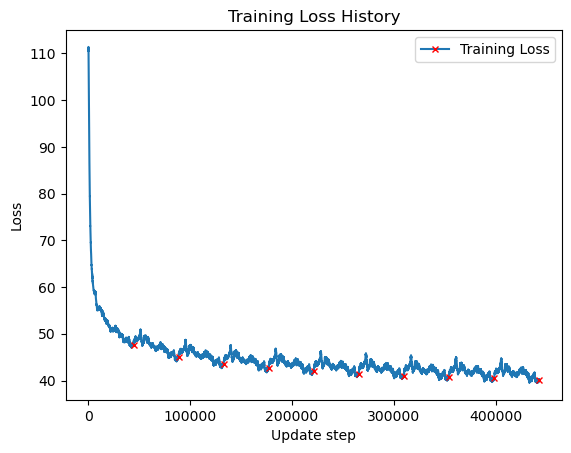

In [54]:
interval = int((len(bookContent) - rnn.seqLength - 1) / rnn.seqLength)
print(interval)
rnn2 = RNN(chars=K, hiddenDim=100, seqLength=25, eta=1e-1)
rnn2.Plot(history, interval)